In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from PIL import Image
from pprint import pprint
from torch.utils.data import DataLoader

In [13]:
def train_test_validate_split(data_list, train_size=0.45, val_size=0.05, test_size=0.5, random_state=None):
    """
    Split a list of dictionaries into training, validation, and test sets.

    Parameters:
    - data_list (list of dict): The data to be split. Each item is a dictionary.
    - train_size (float): Proportion of the data to include in the training set.
    - val_size (float): Proportion of the data to include in the validation set.
    - test_size (float): Proportion of the data to include in the test set.
    - random_state (int, optional): Seed for the random number generator for reproducibility.

    Returns:
    - tuple: Three lists of dictionaries corresponding to (train_data, val_data, test_data).
    """
    
    # Check that the sizes sum to 1
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("Train, validation, and test sizes must sum to 1.")
    
    # Shuffle the list
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(data_list)

    # Calculate the split indices
    num_samples = len(data_list)
    train_end = int(train_size * num_samples)
    val_end = train_end + int(val_size * num_samples)

    # Split the data
    train_data = data_list[:train_end]
    val_data = data_list[train_end:val_end]
    test_data = data_list[val_end:]

    return train_data, val_data, test_data

In [14]:
def load_data(directory):
    image_dict_list = []
    temp_dict = {}
    
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            file_path = os.path.join(directory, filename)
            
            with Image.open(file_path) as img:
                tag = str(filename[9:15])

                # Convert image to numpy array and append to list
                img_array = np.array(img)

                if 'depth_annotated' in filename:
                    img_array = img_array / 255.0

                version = ''
                if '_rgb' in filename:
                    version = 'image'
                elif '_depth.' in filename:
                    version = 'depth_raw'
                else:
                    version = 'depth_mask'

                if tag in temp_dict:
                    temp_dict[tag][version] = img_array
                else:
                    temp_dict[tag] = {version : img_array}
                
    for key in temp_dict:
        image_dict_list.append(temp_dict[key])
    
    # Convert list of arrays into a single numpy array
    # return np.stack(image_dict_list, axis=0)  # shape: (num_images, height, width, channels)
    return image_dict_list


In [4]:
dataset = load_data('Annotated_data')

In [15]:
# init train, val, test sets
train_dataset, valid_dataset, test_dataset = train_test_validate_split(dataset)

In [16]:
# # It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames)) 
# assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 25
Valid size: 2
Test size: 29


In [22]:
# Check image properties for a sample from each dataset

def check_image_properties(sample):
    image = sample["depth_raw"]
    mask = sample["depth_mask"]

    print("Image shape:", image.shape)
    print("Image dtype:", image.dtype)
    print("Image range:", (image.min(), image.max()))
    
    print("Mask shape:", mask.shape)
    print("Mask dtype:", mask.dtype)
    print("Mask range:", (mask.min(), mask.max()))

# Check properties for train, validation, and test datasets
print("Train dataset sample:")
check_image_properties(train_dataset[0])

print("\nValidation dataset sample:")
check_image_properties(valid_dataset[0])

print("\nTest dataset sample:")
check_image_properties(test_dataset[0])


Train dataset sample:
Image shape: (480, 640)
Image dtype: uint8
Image range: (0, 255)
Mask shape: (480, 640, 3)
Mask dtype: float64
Mask range: (0.0, 1.0)

Validation dataset sample:
Image shape: (480, 640)
Image dtype: uint8
Image range: (0, 255)
Mask shape: (480, 640, 3)
Mask dtype: float64
Mask range: (0.0, 1.0)

Test dataset sample:
Image shape: (480, 640)
Image dtype: uint8
Image range: (0, 255)
Mask shape: (480, 640, 3)
Mask dtype: float64
Mask range: (0.0, 1.0)


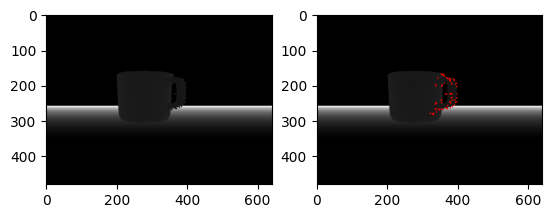

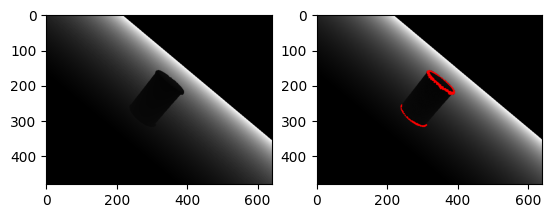

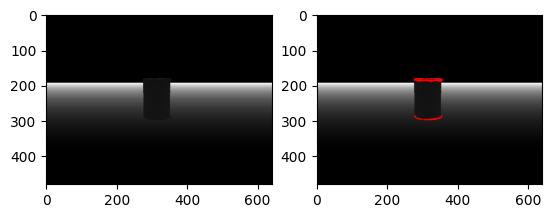

In [17]:
sample = train_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(0, 1, 2)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,1)
plt.imshow(sample["depth_raw"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.subplot(1,2,2)
plt.imshow(sample["depth_mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["depth_raw"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.subplot(1,2,2)
plt.imshow(sample["depth_mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["depth_raw"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.subplot(1,2,2)
plt.imshow(sample["depth_mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask 
plt.show()

In [18]:
class GraspModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]
        image = image.permute(0, 3, 1, 2)  # Change shape from (N, H, W, C) to (N, C, H, W)
        print('\n##################', image.shape)

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["depth_mask"]
        mask = mask.permute(0, 3, 1, 2)
        # Debugging: Print min and max of mask
        print(f"\nMask min: {mask.min().item()}, max: {mask.max().item()}")
        print(f"Image shape: {image.shape}")
        print(f"Mask shape: {mask.shape}")

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        print(f"Logits mask shape: {logits_mask.shape}")
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [19]:
model = GraspModel("Unet", "resnet50", in_channels=3, out_classes=1)

In [20]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 32.5 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]
################## torch.Size([2, 3, 480, 640])

Mask min: 0.0, max: 1.0
Image shape: torch.Size([2, 3, 480, 640])
Mask shape: torch.Size([2, 3, 480, 640])
Logits mask shape: torch.Size([2, 1, 480, 640])


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()